In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import datetime as dt
from copy import deepcopy as dc
# from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
# from tensorflow.keras import layers
# from tensorflow.keras.layers import *
# from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras.losses import MeanSquaredError
# from tensorflow.keras.metrics import RootMeanSquaredError
# from tensorflow.keras.optimizers import Adam
from keras.models import load_model

from api_keys import coinapi_key

2023-09-12 19:57:55.892368: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#  https://docs.coinapi.io/market-data/rest-api/ohlcv
# Pull BTC data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_ETH_USD/history?period_id=1DAY&&time_start=2021-01-02T00:00:00&limit=10000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2021-01-02T00:00:00.0000000Z', 'time_period_end': '2021-01-03T00:00:00.0000000Z', 'time_open': '2021-01-02T00:00:06.2670000Z', 'time_close': '2021-01-02T23:59:58.5200000Z', 'price_open': 731.99, 'price_high': 788.82, 'price_low': 717, 'price_close': 775.59, 'volume_traded': 101732.13526586, 'trades_count': 20202}, {'time_period_start': '2021-01-03T00:00:00.0000000Z', 'time_period_end': '2021-01-04T00:00:00.0000000Z', 'time_open': '2021-01-03T00:00:06.1450000Z', 'time_close': '2021-01-03T23:59:59.3780000Z', 'price_open': 775.4, 'price_high': 1014.7, 'price_low': 769.95, 'price_close': 979.33, 'volume_traded': 256214.08926463, 'trades_count': 58103}, {'time_period_start': '2021-01-04T00:00:00.0000000Z', 'time_period_end': '2021-01-05T00:00:00.0000000Z', 'time_open': '2021-01-04T00:00:03.1380000Z', 'time_close': '2021-01-04T23:59:55.0430000Z', 'price_open': 980.23, 'price_high': 1169.97, 'price_low': 890, 'price_close': 1042.95, 'volume_traded': 319719.31834411, 't

In [3]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2021-01-02T00:00:00.0000000Z,2021-01-03T00:00:00.0000000Z,2021-01-02T00:00:06.2670000Z,2021-01-02T23:59:58.5200000Z,731.99,788.82,717.00,775.59,101732.135266,20202
1,2021-01-03T00:00:00.0000000Z,2021-01-04T00:00:00.0000000Z,2021-01-03T00:00:06.1450000Z,2021-01-03T23:59:59.3780000Z,775.40,1014.70,769.95,979.33,256214.089265,58103
2,2021-01-04T00:00:00.0000000Z,2021-01-05T00:00:00.0000000Z,2021-01-04T00:00:03.1380000Z,2021-01-04T23:59:55.0430000Z,980.23,1169.97,890.00,1042.95,319719.318344,72301
3,2021-01-05T00:00:00.0000000Z,2021-01-06T00:00:00.0000000Z,2021-01-05T00:00:08.1140000Z,2021-01-05T23:59:57.9450000Z,1045.65,1136.00,975.00,1102.97,302282.874882,57783
4,2021-01-06T00:00:00.0000000Z,2021-01-07T00:00:00.0000000Z,2021-01-06T00:00:00.9530000Z,2021-01-06T23:59:55.4230000Z,1102.97,1215.00,1059.73,1212.85,219418.464095,52756


In [4]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
# data = data.reindex(index=data.index[::-1])

#set date as index
data.set_index('Date', inplace=True)

data

,Close
Date,
2021-01-02,775.59
2021-01-03,979.33
2021-01-04,1042.95
2021-01-05,1102.97
2021-01-06,1212.85
...,...
2023-09-08,1636.00
2023-09-09,1635.30
2023-09-10,1616.80


In [5]:
close = data['Close']

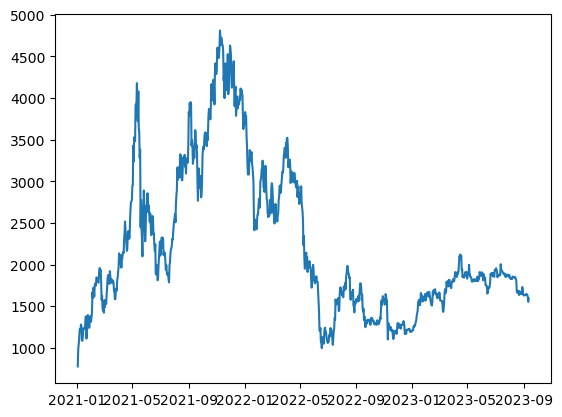

In [6]:
#plot historical eth price
plt.plot(close)

In [7]:
# build 1 month lookback for lstm training
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

lookback = 6
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6)
Date,,,,,,,
2021-01-08,1217.84,1226.56,1212.85,1102.97,1042.95,979.33,775.59
2021-01-09,1280.11,1217.84,1226.56,1212.85,1102.97,1042.95,979.33
2021-01-10,1256.00,1280.11,1217.84,1226.56,1212.85,1102.97,1042.95
2021-01-11,1087.82,1256.00,1280.11,1217.84,1226.56,1212.85,1102.97
2021-01-12,1083.62,1087.82,1256.00,1280.11,1217.84,1226.56,1212.85
...,...,...,...,...,...,...,...
2023-09-08,1636.00,1647.90,1632.20,1634.00,1629.70,1635.80,1637.10
2023-09-09,1635.30,1636.00,1647.90,1632.20,1634.00,1629.70,1635.80
2023-09-10,1616.80,1635.30,1636.00,1647.90,1632.20,1634.00,1629.70


In [8]:
#create array of dates for plotting from index. Must be shifted by 7 to match time series data, 
# since time series is 7 days and does not generate until the 7th day
# data starts on 9/13/11, but series don't start until 9/20
dates = data.index
dates = dates[lookback:]
dates.shape

(970,)

In [9]:
#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np


shifted_df_as_np_int = shifted_df_as_np.astype(int)
log_transformed_data = np.log(shifted_df_as_np_int)

log_transformed_data.shape

(970, 7)

In [10]:
model = load_model("H5_Files/ETH_30_day_lookback.h5")

2023-09-12 19:58:09.240419: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 120

#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = log_transformed_data[-1].reshape((1, 7, 1))
initial_date = dates[-1]

for i in range(prediction_range):  # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model.predict(current_batch)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        
    # Shift the current batch one step forward
    current_batch = np.roll(current_batch, shift=-1, axis=1)
    current_batch[0, -1, 0] = current_pred
    

    
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
#'predictions' contains forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 70ms/step
[7.42842, 7.44955, 7.473623, 7.4974737, 7.5211596, 7.5447364, 7.568232, 7.591569, 7.614777, 7.6378345, 7.6607404, 7.683488, 7.706073, 7.7284856, 7.750724, 7.7727804, 7.7946467, 7.816319, 7.837792, 7.859058, 7.880113, 7.900951, 7.921566, 7.941952, 7.9621053, 7.9820194, 8.001691, 8.0211115, 8.040281, 8.059195, 8.077845, 8.09623, 8.114345, 8.132189, 8.149756, 8.167044, 8.18405, 8.200773, 8.217209, 8.233355, 8.249212, 8.26478, 8.280055, 8.295038, 8.309717, 8.323981, 8.337863, 8.35136, 8.364481, 8.37723, 8.389611, 8.401631, 8.413297, 8.424251, 8.433761, 8.442269, 8.449844, 8.456606, 8.462644, 8.468033, 8.472841, 8.477131, 8.480957, 8.484371, 8.487417, 8.490132, 8.492556, 8.494715, 8.496641, 8.498358, 8.499889, 8.501253, 8.502471, 8.503557, 8.504524, 8.505387, 8.506156, 8.50684, 8.507451, 8.507995, 8.50848, 8.508913, 8.5093, 8.509644, 8.509951, 8.510224, 8.510468, 8.510686, 8.510879, 8.51105, 8.511203, 8.51134, 8.511461, 8.51157, 8.511668, 

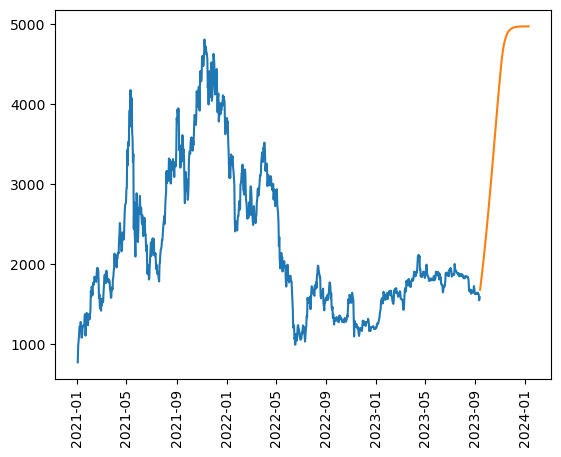

In [12]:
plt.plot(close)
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)

plt.show()